## Technical Quality Decision Tree

### Goal
This script is meant for training a BIQA decsion tree on the KonIQ-10k dataset. The KonIQ-10k contains images and their MOS-scores based on technical image quality. 

### Script
By calling get_features( ) 16 features will be extracted from an image. Subsequently it is possible to export an animated GIF is needed.  


### Additional Remarks
* Please note that I did not include the dataset in this Git repository. You can download the original dataset by using the following link: http://database.mmsp-kn.de/koniq-10k-database.html. 
* Most of the code I wrote myself. However, when external code is used, the source is referenced. 

In [1]:
import numpy as np
import pandas as pd 

from skimage import io, color, exposure, filters, measure, util
from skimage.transform import resize

from PIL import Image 

from scipy import stats
import scipy.ndimage.filters

from sklearn import cluster
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from celluloid import Camera
import matplotlib.animation as matplotlib_animation

import warnings
warnings.filterwarnings('ignore')

In [386]:
def get_features(full_img, rescale_factor, animation):
    
    # Image preprocessing: rescaling and clustering 
    rescaled_img, rescaled_img_gray, mode = preprocess(full_img, rescale_factor)
    rescaled_img_luv, kmeans_cluster, rescaled_img_range = segmentation(rescaled_img, rescaled_img_gray, mode, True)
    
    # Calculate features for rescaled image and clusters 
    exposure, contrast = feature_exposure(rescaled_img_gray) 
    rescaled_img_hsv, saturation = feature_saturation(rescaled_img, mode)
    var_0, max_0, len_0, var_1, max_1, len_1, var_2, max_2, len_2, number_areas, rescaled_laplacian = feature_segments(rescaled_img, kmeans_cluster, rescaled_img_range)
    
    # Calculate cropped image by salience 
    center_y, center_x, salience_img, salience_img_th = calculate_salience(rescaled_img_gray, rescaled_img_range, rescaled_img_hsv, rescale_factor, mode) 
    cropped_img, cropped_img_gray = salience_crop(center_x, center_y, full_img, rescale_factor, mode)
    
    # Calculate features for cropped image (more detail)
    cropped_img_luv, cropped_kmeans_cluster, cropped_img_range = segmentation(cropped_img, cropped_img_gray, mode, False)
    var_crop_0, var_crop_1, noise_crop = feature_crop(cropped_img, cropped_kmeans_cluster, cropped_img_range)
    
    process_animation = 0
    
    # load gif for animation of process  
    if animation == True:
        fig = plt.figure(frameon = False, dpi = 100)
        fig.set_size_inches(2.24, 2.24)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        animation_ims = []
        image_list = [rescaled_img, rescaled_img, kmeans_cluster, rescaled_laplacian, salience_img, salience_img_th, rescaled_img, cropped_img, cropped_img]
        for i, image in enumerate(image_list):
            frame = ax.imshow(image, cmap = 'gray', aspect = 'auto')
            animation_ims.append([frame])
            if 5 <= i <= 6:
                dot = ax.plot(center_x * rescale_factor, center_y * rescale_factor, marker = 'o', markerfacecolor = '#13e27a', markeredgecolor = '#13e27a')
                animation_ims[i].append(dot[0])
        process_animation = matplotlib_animation.ArtistAnimation(fig, animation_ims, interval=2000, blit=True, repeat_delay=0)
        writer = matplotlib_animation.PillowWriter()
#         process_animation.save('testtettest_animation.gif', writer = writer)
    return({'features': [exposure, contrast, saturation, number_areas, len_0, len_1, len_2, var_0, max_0, var_1, max_1, var_2, max_2, var_crop_0, var_crop_1, noise_crop], 'visuals': process_animation})


In [387]:
def preprocess(full_img, rescale_factor):
    rescaled_img = resize(full_img, (rescale_factor, rescale_factor), anti_aliasing = True)
    if rescaled_img.shape != (rescale_factor, rescale_factor, 3):
        mode = 'grayscale'
        rescaled_img_grayscale = rescaled_img 
    elif np.array_equal(rescaled_img[:, :, 0], rescaled_img[:, :, 1]) and np.array_equal(rescaled_img[:, :, 0], rescaled_img[:, :, 2]):
        mode = 'grayscale'
        rescaled_img_gray = color.rgb2gray(rescaled_img)
    else:
        mode = 'color'
        rescaled_img_gray = color.rgb2gray(rescaled_img)
    return(rescaled_img, rescaled_img_gray, mode)

def segmentation(img, img_gray, mode, calculate_number_clusters):     
    img_range = (img_gray - np.amin(img_gray)) * 255.0 / (np.amax(img_gray) - np.amin(img_gray))
 
    if mode == 'color':
        img_luv = color.rgb2luv(img)
    else:
        img_luv = np.stack((img_range, img_range, img_range), axis = 2)   

    img_med = scipy.ndimage.median_filter(img_luv, size = 2)
    
    x, y = img.shape[:2]
    img_reshape = img_med.reshape(x*y, 3)

    if calculate_number_clusters == True:              
        distortions = []
        for i in range(1, 4):
            kmeans = cluster.MiniBatchKMeans(max_iter = 2, batch_size = 2000, n_clusters = i)
            kmeans.fit(img_reshape)
            distortions.append(kmeans.inertia_)

        coef = []
        change_coef = []

        for i in range(1, 3):
            coef.append((distortions[i - 1] / distortions[i]))

        for i in range(1, 2):
            change_coef.append(coef[i] / coef[i - 1])

        count_k = 2
        for number in change_coef[1:]:
            if number < 0.8:
                count_k += 1
            else:
                break
    else:
        count_k = 2 

    kmeans = cluster.MiniBatchKMeans(max_iter = 10, batch_size = 2000, n_clusters = count_k)
    kmeans.fit(img_reshape)
    centers = kmeans.cluster_centers_
    labels = (kmeans.labels_)
    clustered = centers[labels].reshape(x, y, 3)
    clustered_int = color.rgb2gray(clustered.astype(int))
    
    return(img_luv, clustered_int, img_range)
    
def calculate_salience(img_gray, img_range, img_hsv, rescale_factor, mode):
#     https://jacobgil.github.io/computervision/saliency-from-backproj
    if mode == 'grayscale':
        black_image = np.zeros((rescale_factor, rescale_factor, 3))
        return(0.5, 0.5, black_image, black_image)

    ravel_sat = np.ravel(img_hsv[:, :, 1])
    ravel_hue = np.ravel(img_hsv[:, :, 0])
    
    full_hist, a, b = np.histogram2d(ravel_sat, ravel_hue, bins = ([0, 0.5, 1]))

    sorted_values = sorted(full_hist.ravel())

    new_image = []
    for i, pixel in enumerate(ravel_sat): 
        if pixel < 0.5:
            if ravel_hue[i] < 0.5: 
                new_pixel = 240 - sorted_values.index(full_hist[0][0]) * 80
            else:
                new_pixel = 240 - sorted_values.index(full_hist[0][1]) * 80
        else:
            if ravel_hue[i] < 0.5: 
                new_pixel = 240 - sorted_values.index(full_hist[1][0]) * 80
            else:
                new_pixel = 240 - sorted_values.index(full_hist[1][1]) * 80
        new_image.append(new_pixel)

    salience_image = np.array(new_image).reshape((rescale_factor, rescale_factor))
    salience_image = scipy.ndimage.gaussian_filter(salience_image, sigma = 8)
    salience_image = exposure.equalize_hist(salience_image)
    
    threshold = filters.threshold_otsu(salience_image)
#     plt.imshow(salience_image, cmap = 'gray')
    salience_image_th = (salience_image > threshold).astype(int)
    
    properties = measure.regionprops(salience_image_th, img_gray)
    weighted_center_of_mass = properties[0].centroid
    
#     fig, ax = plt.subplots()
#     ax.imshow(salience_image_th, cmap=plt.cm.gray)
            
#     ax.plot(weighted_center_of_mass[1], weighted_center_of_mass[0], 'ro')

#     ax.axis('image')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.show()
    
    return(weighted_center_of_mass[0]/rescale_factor, weighted_center_of_mass[1]/rescale_factor, salience_image, salience_image_th)

def salience_crop(center_x, center_y, full_img, rescale_factor, mode):
    height, width = full_img.shape[:2]
    x = int(center_x * width)
    y = int(center_y * height)
    original_x, original_y = x, y
    
    half_crop = 0.5 * rescale_factor
    
    if x < half_crop:
        x = half_crop 
    if y < half_crop:
        y = half_crop 
        
    if (width - x) < half_crop:
        x = width - half_crop 
    if (height - y) < half_crop:
        y = height - half_crop
    
#     fig, ax = plt.subplots()
#     ax.imshow(full_img, cmap=plt.cm.gray)
            
#     ax.plot(original_x, original_y, 'ro')
    
    x_min = int(x - half_crop)
    x_max = int(x + half_crop)
    y_min = int(y - half_crop)
    y_max = int(y + half_crop)       
    
    bounding_box = patches.Rectangle((x_min, y_min), rescale_factor, rescale_factor, linewidth = 2, edgecolor = 'r', facecolor = 'none')
#     ax.add_patch(bounding_box)
#     ax.axis('image')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.show()
    
#     plt.show()

    img_crop = full_img[y_min:y_max, x_min:x_max]
    if mode == 'grayscale':
        img_crop_gray = img_crop
    else:
        img_crop_gray = color.rgb2gray(img_crop)
    
#     plt.imshow(img_crop)
    
    return(img_crop, img_crop_gray)
    

In [388]:
def feature_exposure(img):
    return((img.ravel()).var(), img.std())

def feature_saturation(img, mode):
    img_hsv = np.zeros((img.shape[0], img.shape[1], 3)) 
    if mode == 'color':
        img_hsv = color.rgb2hsv(img)
    saturation = img_hsv[:, :, 1]
    mean_saturation = np.array(saturation).mean() 
    return(img_hsv, mean_saturation)
    
def feature_segments(img, kmeans_cluster, img_range):
    seg_ravel = kmeans_cluster.ravel()
    
    kernel = np.ones((3, 3))
    kernel[1,1] = -8
    laplacian = scipy.ndimage.filters.convolve(img_range, kernel)
    ravel_laplacian = laplacian.ravel()
    
    ravel_img = img.ravel()

    areas = []
    for item in np.unique(seg_ravel):
        list_laplacian = []
        list_img = []
        for i, pixel in enumerate(seg_ravel):
            if pixel == item:
                list_laplacian.append(ravel_laplacian[i])
                list_img.append(ravel_img[i])
        array_img = np.array(list_img)
        array_laplacian = np.array(list_laplacian)
        areas.append([array_laplacian.var(), array_laplacian.max(), len(array_img)/len(seg_ravel)])
        
    number_clusters = len(areas) 

    for i in range(number_clusters, 3):
        areas.append([0, 0, 0])    

    def key(item):
        return(item[2])

    sorted_areas = sorted(areas, key = key)

    return(sorted_areas[0][0], sorted_areas[0][1], sorted_areas[0][2],
            sorted_areas[1][0], sorted_areas[1][1], sorted_areas[1][2],
            sorted_areas[2][0], sorted_areas[2][1], sorted_areas[2][2],
            number_clusters, laplacian)

def feature_crop(img, kmeans_cluster, img_range):
    seg_ravel = kmeans_cluster.ravel()
    
    kernel = np.ones((3, 3))
    kernel[1,1] = -8
    laplacian = scipy.ndimage.filters.convolve(img_range, kernel)
    ravel_laplacian = laplacian.ravel()

    areas = []
    for item in np.unique(seg_ravel):
        list_laplacian = []
        for i, pixel in enumerate(seg_ravel):
            if pixel == item:
                list_laplacian.append(ravel_laplacian[i])
        array_laplacian = np.array(list_laplacian)
        areas.append(array_laplacian.var())   
    sorted_areas = sorted(areas)
    
    full_laplacian = sorted(ravel_laplacian)
    noise_correction = int(len(full_laplacian) * 0.98)
    corrected_laplacian = full_laplacian[:noise_correction]
    noise = np.array(corrected_laplacian).max() / np.array(full_laplacian).max()

    return(sorted_areas[0], sorted_areas[1], noise)

def calculate_similarity(img1, img2):
    similarity = np.sum((img1.astype(float) - img2.astype(float)) ** 2)
    similarity = similarity / float(img1.shape[0] * img1.shape[1])
    return(similarity) 

10113730664.jpg
[0.0392692569958644, 0.1981647218751723, 0.5585314279215609, 2, 0, 0.30819515306122447, 0.6918048469387755, 0, 0, 8807.106408575713, 599.4082968389046, 6418.806292459769, 584.5930424383939, 18755.663594135833, 50732.063933226054, 0.40057772163430483]
10115071674.jpg
[0.055895602883734845, 0.23642250925775837, 0.36842932326783184, 2, 0, 0.2823860012755102, 0.7176139987244898, 0, 0, 11541.676200006263, 610.6425143978038, 4336.592346269014, 791.9594362271616, 10397.79741947042, 55064.50489630586, 0.44673826974554826]
10118773964.jpg
[0.05259800397514172, 0.22934254724133007, 0.252358763533703, 2, 0, 0.208984375, 0.791015625, 0, 0, 5169.964124357936, 407.99723745362246, 4300.213875136587, 434.35097175515847, 10034.750763525555, 99252.26587722379, 0.19935085213898412]
10121813934.jpg
[0.04096960869059807, 0.20240950741157904, 0.5346935918952525, 2, 0, 0.47716039540816324, 0.5228396045918368, 0, 0, 13857.302849483483, 763.5836276701317, 7591.6510894985695, 645.9285854095415, 

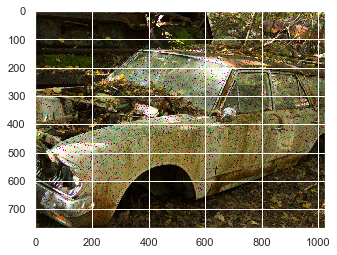

In [389]:
data = pd.read_csv('data/koniq10k_scores_and_distributions.csv')
# data = data[46:47]
data = data[46:50]


for index, row in data.iterrows():
    if index % 50 == 0:
        print(index)
        print(datetime.now())
    name = row['image_name']
    print(name)
    score = row['MOS']
    
    full_img = io.imread('data/1024x768/' + name)
    full_img = util.random_noise(full_img, 'pepper', amount = 0.05)
    plt.imshow(full_img)

    features_animation = get_features(full_img, 224, animation = False)
    features = features_animation.get('features')
    print(features)
#     df = features_to_df(features.get('features'))
#     print(df)
#     print(features_from_df(df, ['brightness', 'noise']))
#     print(features)

In [390]:
all_categories = ['brightness', 'contrast', 'color', 'areas', 'sharpness', 'noise'] 
selected_categories = ['brightness', 'contrast', 'color', 'areas', 'sharpness', 'noise']
feature_list = []
for category in all_categories:
    features_in_category = features.get('features').get(category)
    if category in selected_categories:
        for feature in features_in_category:
            feature_list.append(feature)
    else: 
        for feature in features_in_category:
            feature_list.append(0)
    
print(feature_list)

AttributeError: 'list' object has no attribute 'get'

In [8]:
# todays_date = datetime.now().date()
# index = pd.date_range(todays_date-datetime.timedelta(10), periods=10, freq='D')
testtt = pd.DataFrame(columns = ['brightness', 'contrast', 'color', 'areas_count', 'areas_0_size', 'areas_1_size', 'areas_2_size', 'sharpness1_area_0', 'sharpness2_area_0', 'sharpness1_area_1', 'sharpness2_area_1', 'sharpness1_area_2', 'sharpness2_area_2', 'sharpness1_crop_0', 'sharpness1_crop_1', 'noise'])
print(type(df))
print(feature_list)
print(type(feature_list))
testtt.loc['image_name'] = feature_list
testtt.loc['image_name2'] = feature_list
# testtt.loc[len(testtt)].index() = 'fgljnfg'
# print(list(testtt.loc['image_name2']))
testtt


NameError: name 'df' is not defined

In [391]:
def features_to_df(feature_list):
    df = pd.DataFrame([feature_list])
    df.columns = ['brightness', 'contrast', 'color', 'areas_count', 'areas_0_size', 'areas_1_size', 'areas_2_size', 'sharpness1_area_0', 'sharpness2_area_0', 'sharpness1_area_1', 'sharpness2_area_1', 'sharpness1_area_2', 'sharpness2_area_2', 'sharpness1_crop_0', 'sharpness1_crop_1', 'noise']
    return(df)
    
    
selected_categories = ['contrast']    
def features_from_df(df, selected_categories):
    dict_features = {'brightness': [], 'contrast': [], 'color': [], 'areas': [], 'sharpness': [], 'noise': []}
    for item, value in df.iteritems():
        for key in dict_features.keys():
            if item.startswith(key):
                current_content = dict_features[key]
                current_content.append(value[0])
                dict_features[key] = current_content
                
    all_categories = ['brightness', 'contrast', 'color', 'areas', 'sharpness', 'noise'] 
    feature_list = []
    for category in all_categories:
        features_in_category = dict_features.get(category)
        if category in selected_categories:
            for feature in features_in_category:
                feature_list.append(feature)
        else: 
            for feature in features_in_category:
                feature_list.append(0)
    return(feature_list)
    

In [392]:
all_categories = ['brightness', 'contrast', 'color', 'areas', 'sharpness', 'noise'] 
feature_list = []
for category in all_categories:
    features_in_category = dict_features.get(category)
    if category in selected_categories:
        for feature in features_in_category:
            feature_list.append(feature)
    else: 
        for feature in features_in_category:
            feature_list.append(0)
    
print(feature_list)

NameError: name 'dict_features' is not defined

In [29]:
import json
errordf = pd.read_csv('traintesterror.csv')
errordf_2 = errordf[errordf['2020-06-09 16:27:43.804770'].str.contains('Error')]
errordf_2

errors = []

for index, row in errordf_2.iterrows():
    str_error = row['2020-06-09 16:27:43.804770']
    str_error = str_error.split('Error ')
    errors.append(str_error[1])
print(errors)

with open('error.json', 'w') as outfile:
    json.dump(errors, outfile)

['10110458216.jpg', '101601008.jpg', '10196228605.jpg', '10209014225.jpg', '10211880874.jpg', '10226277514.jpg', '10693826785.jpg', '10715577856.jpg', '10728525673.jpg', '10745415703.jpg', '11310848503.jpg', '11511265293.jpg', '115290990.jpg', '1316239068.jpg', '1367218588.jpg', '1413089132.jpg', '1429120335.jpg', '16057476.jpg', '1669800671.jpg', '186520031.jpg', '187485230.jpg', '2055589084.jpg', '208949930.jpg', '2223255997.jpg', '2224984425.jpg', '2269141846.jpg', '2297923850.jpg', '2349676135.jpg', '2460847286.jpg', '2478250944.jpg', '2539818768.jpg', '2688019250.jpg', '2998270477.jpg', '3078720945.jpg', '3108798537.jpg', '31490353.jpg', '3243501762.jpg', '326195053.jpg', '331340631.jpg', '3342346685.jpg', '3355209894.jpg', '3367803108.jpg', '3491336743.jpg', '3492624391.jpg', '3612174577.jpg', '3653613515.jpg', '3716186057.jpg', '3758636614.jpg', '376684942.jpg', '3812865597.jpg', '3892332557.jpg', '392103652.jpg', '3927881802.jpg', '3964553280.jpg', '3978652004.jpg', '4034220859

In [291]:
data = pd.read_csv('data/koniq10k_scores_and_distributions.csv')
# data = data[:5000]
X = []
y = []

for index, row in data.iterrows():
    if index % 50 == 0:
        print(index)
        print(datetime.now())
    name = row['image_name']
    score = row['MOS_zscore']
    
    try:
        full_img = io.imread('data/1024x768/' + name)
        features_animation = get_features(full_img, 224, animation = False)
        features = features_animation.get('features')
        y.append(score)
        X.append(features)
    except:
        print('Error ' + name)

0
2020-06-09 16:27:43.804770
Error 10110458216.jpg
50
2020-06-09 16:28:24.960917
Error 101601008.jpg
Error 10196228605.jpg
Error 10209014225.jpg
Error 10211880874.jpg
Error 10226277514.jpg
100
2020-06-09 16:29:07.931223
150
2020-06-09 16:29:49.664035
200
2020-06-09 16:30:31.568643
250
2020-06-09 16:31:14.114978
Error 10693826785.jpg
300
2020-06-09 16:31:55.108823
Error 10715577856.jpg
Error 10728525673.jpg
Error 10745415703.jpg
350
2020-06-09 16:32:36.934252
400
2020-06-09 16:33:17.572392
450
2020-06-09 16:34:03.869636
500
2020-06-09 16:34:46.612512
Error 11310848503.jpg
550
2020-06-09 16:35:25.691589
600
2020-06-09 16:36:07.030880
Error 11511265293.jpg
Error 115290990.jpg
650
2020-06-09 16:36:47.931670
Error 1316239068.jpg
700
2020-06-09 16:37:28.407766
Error 1367218588.jpg
Error 1413089132.jpg
Error 1429120335.jpg
750
2020-06-09 16:38:09.351167
800
2020-06-09 16:38:53.804480
Error 16057476.jpg
Error 1669800671.jpg
850
2020-06-09 16:39:36.732218
Error 186520031.jpg
Error 187485230.jpg

7600
2020-06-09 18:20:48.741625
7650
2020-06-09 18:21:28.300375
Error 7940282852.jpg
7700
2020-06-09 18:22:07.656970
7750
2020-06-09 18:22:47.326402
Error 8020739978.jpg
7800
2020-06-09 18:23:26.552147
Error 8074116162.jpg
7850
2020-06-09 18:24:05.063025
Error 8090361774.jpg
7900
2020-06-09 18:24:44.613540
Error 8108912190.jpg
Error 8126953338.jpg
7950
2020-06-09 18:25:23.674208
Error 8163644568.jpg
8000
2020-06-09 18:26:04.129282
Error 8182393998.jpg
Error 8185807831.jpg
8050
2020-06-09 18:26:43.115065
Error 8223457724.jpg
8100
2020-06-09 18:27:22.434056
Error 8230351643.jpg
Error 8240021404.jpg
8150
2020-06-09 18:28:00.971840
Error 8263420706.jpg
Error 8273944978.jpg
8200
2020-06-09 18:28:41.276117
Error 8305612260.jpg
Error 8306770184.jpg
8250
2020-06-09 18:29:20.275461
8300
2020-06-09 18:30:01.707253
Error 8348113359.jpg
Error 8351568109.jpg
Error 8354479425.jpg
8350
2020-06-09 18:30:40.183695
8400
2020-06-09 18:31:21.788408
8450
2020-06-09 18:32:00.617637
Error 8430377800.jpg
Erro

In [401]:
data = pd.read_csv('data/koniq10k_distributions_sets.csv')
# data = data[:30]
X_train_same = []
X_test_same = []
y_train_same = []
y_test_same = []

with open('error.json', 'r') as errorfile:
    error_list = json.load(errorfile)

for index, row in data.iterrows():
    if index % 200 == 0:
        print(index)
        print(datetime.now())
    name = row['image_name']
    score = row['MOS']
    if name not in error_list:
        if row['set'] == 'test':
            try:
                full_img = io.imread('data/1024x768/' + name)
                features_animation = get_features(full_img, 224, animation = False)
                features = features_animation.get('features')
                y_test_same.append(score)
                X_test_same.append(features)
            except:
                print('Error test' + name)
        if row['set'] == 'training': 
            try:
                full_img = io.imread('data/1024x768/' + name)
                features_animation = get_features(full_img, 224, animation = False)
                features = features_animation.get('features')
                y_train_same.append(score)
                X_train_same.append(features)
            except:
                print('Error train' + name)

0
2020-06-29 17:59:11.609250
200
2020-06-29 18:01:30.715785
400
2020-06-29 18:03:50.977488
600
2020-06-29 18:06:36.066063
800
2020-06-29 18:09:23.865813
1000
2020-06-29 18:12:28.463187
1200
2020-06-29 18:15:17.295570
1400
2020-06-29 18:18:05.289418
1600
2020-06-29 18:20:55.612028
1800
2020-06-29 18:23:49.052798
2000
2020-06-29 18:26:43.762607
2200
2020-06-29 18:29:31.899948
2400
2020-06-29 18:32:13.309926
2600
2020-06-29 18:34:57.494090
2800
2020-06-29 18:37:31.540292
3000
2020-06-29 18:40:35.679665
3200
2020-06-29 18:43:46.056932
3400
2020-06-29 18:46:33.946591
3600
2020-06-29 18:49:16.775991
3800
2020-06-29 18:51:48.237882
4000
2020-06-29 18:54:35.311545
4200
2020-06-29 18:57:15.008554
4400
2020-06-29 18:59:40.413311
4600
2020-06-29 19:01:52.180662
4800
2020-06-29 19:04:09.243800
5000
2020-06-29 19:06:18.156223
5200
2020-06-29 19:08:37.174001
5400
2020-06-29 19:10:53.801027
5600
2020-06-29 19:13:14.391891
5800
2020-06-29 19:15:29.771677
6000
2020-06-29 19:17:45.037146
6200
2020-06-29

In [409]:
# print(len(X_test_same))
# print(len(y_test_same))
# print(len(X_train_same))
# print(len(y_train_same))

# with open('X_test_KonIQ.json', 'w') as outfile:
#     json.dump(X_test_same, outfile)
    
# with open('y_test_KonIQ.json', 'w') as outfile:
#     json.dump(y_test_same, outfile)
    
# with open('X_train_KonIQ.json', 'w') as outfile:
#     json.dump(X_test_same, outfile)
    
# with open('y_train_KonIQ.json', 'w') as outfile:
#     json.dump(y_test_same, outfile)

regressor = tree.DecisionTreeRegressor(max_depth = 6, min_samples_split = 150, min_samples_leaf = 1)
regressor = regressor.fit(X_train_same, y_train_same)

predicted = regressor.predict(X_test_same)

actual = y_test_same
plcc, p_plcc = stats.pearsonr(predicted, actual)
srocc, p_srocc = stats.spearmanr(predicted, actual)
print('plcc', plcc)
print('srocc', srocc)

plcc 0.6483407229190744
srocc 0.6172602586668006


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

median plcc:  0.6411538492407503
median srocc:  0.6107018445670107
1 0.013154442057734562
2 0.013279996894370993
3 0.0701960918508033
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.004600517965620318
11 0.09829265364432348
12 0.06499720670428695
13 0.48243016231374103
14 0.06258676607277779
15 0.1625528833807967
16 0.02012137351638249


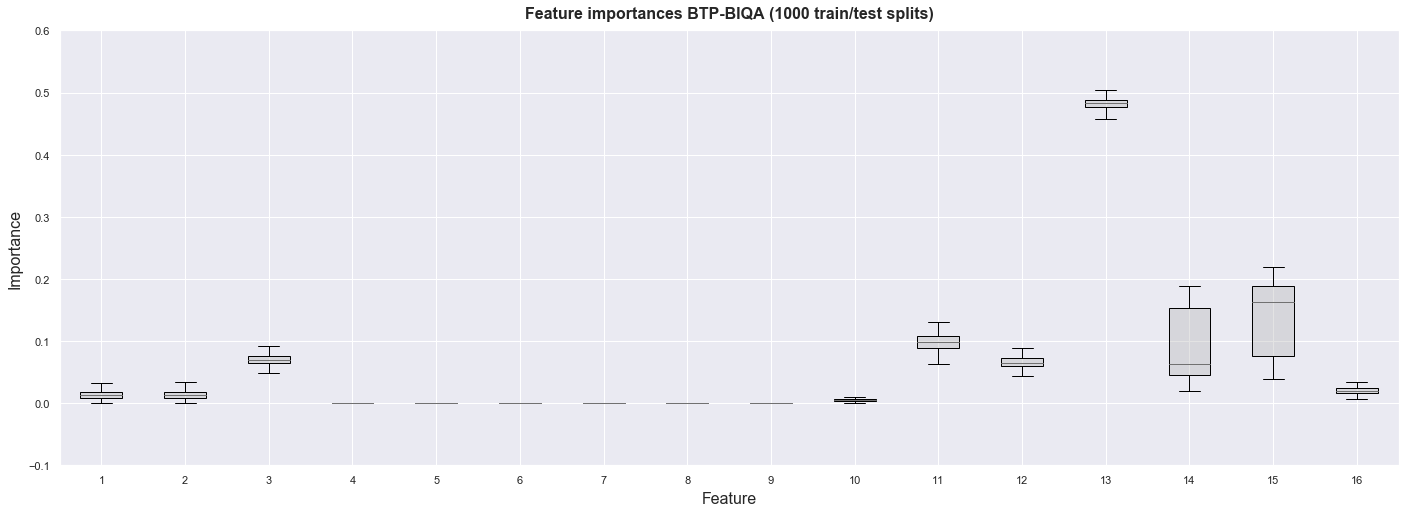

In [368]:
import statistics

# with open('features_y_train.json') as jsonytrain:
#     y_train_new = json.load(jsonytrain)
    
# with open('features_y_test.json') as jsonytest:
#     y_test_new = json.load(jsonytest)
    
# with open('features_X_train.json') as jsonXtrain:
#     X_train_new = json.load(jsonXtrain)
    
# with open('features_X_test.json') as jsonXtest:
#     X_test_new = json.load(jsonXtest)
    
# X_new = X_train_new + X_test_new
# y_new = y_train_new + y_test_new
# # print(len(y_new) == len(X_new))

# all_plcc = []
# all_srocc = []
# importances = [[] for x in range(16)]

# for i in range(1000): 
# #     print(i)

#     X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2, random_state = i)

#     regressor = tree.DecisionTreeRegressor(max_depth = 6, min_samples_split = 150, min_samples_leaf = 1)
#     regressor = regressor.fit(X_train_new, y_train_new)
    
#     feature_importances = regressor.feature_importances_
#     for i in range(len(feature_importances)):
#         importance = feature_importances[i]
#         importances[i].append(importance)

#     predicted = regressor.predict(X_test_new)

#     actual = y_test_new
#     plcc, p_plcc = stats.pearsonr(predicted, actual)
#     srocc, p_srocc = stats.spearmanr(predicted, actual)
#     all_plcc.append(plcc)
#     all_srocc.append(srocc)

print('median plcc: ', statistics.median(all_plcc))
print('median srocc: ', statistics.median(all_srocc))
# regressor = pickle.load(open('used_in_app_model.sav', 'rb'))
# print(regressor.get_params())

fig, ax = plt.subplots(figsize = (24, 8))
plt.ylim(-0.1, 0.6)
plt.title('Feature importances BTP-BIQA (1000 train/test splits)', pad = 12, fontweight = 'bold', linespacing = 1.8, fontsize = 16)
plt.xlabel('Feature', labelpad = 6, fontsize = 16)
plt.ylabel('Importance', labelpad = 6, fontsize = 16)
# plt.tick_params(axis = 'both', labelsize = 12)
median_style = {'color': '#717171'}
boxplot = plt.boxplot(importances, medianprops = median_style, patch_artist = True, showfliers = False)
for box in boxplot['boxes']:
    box.set_facecolor('#b5b5b560')
    
for i, feature in enumerate(importances):
    print(i + 1, statistics.median(feature))
    
plt.savefig('Feature importances BTP-BIQA 29-6.png', dpi=300)    

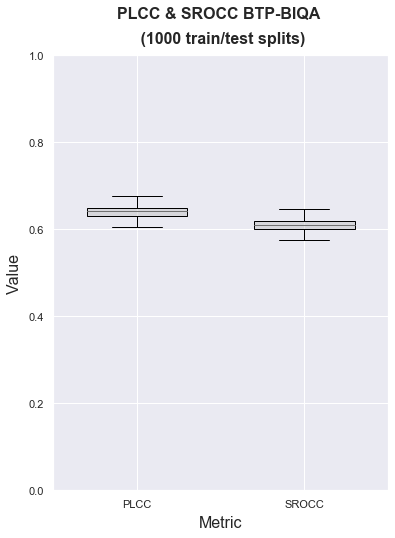

In [369]:
fig, ax = plt.subplots(figsize = (6, 8))
plt.ylim(-0.0, 1.0)
plt.title('PLCC & SROCC BTP-BIQA \n (1000 train/test splits)', pad = 12, fontweight = 'bold', linespacing = 1.8, fontsize = 16)
plt.xlabel('Metric', labelpad = 6, fontsize = 16)
plt.ylabel('Value', labelpad = 6, fontsize = 16)
median_style = {'color': '#717171'}
boxplot = plt.boxplot([all_plcc, all_srocc], medianprops = median_style, patch_artist = True, showfliers = False, labels = ['PLCC', 'SROCC'], widths = (0.6, 0.6))
for box in boxplot['boxes']:
    box.set_facecolor('#b5b5b560')
    
plt.savefig('PLCC-SROCC BTP-BIQA 29-6.png', dpi=300)    

{'criterion': 'mse', 'max_depth': 6, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 150, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}

In [30]:
data = pd.read_csv('data/koniq10k_scores_and_distributions.csv')
X2 = []
y2 = []

for index, row in data.iterrows():
#     if index % 50 == 0:
#         print(index)
#         print(datetime.now())
    name = row['image_name']
    score = row['MOS_zscore']
    
    try:
        if name not in errors:
#             full_img = io.imread('data/1024x768/' + name)
#             features_animation = get_features(full_img, 224, animation = False)
#             features = features_animation.get('features')
            y2.append(score)
            X2.append([1, 1])
    except:
        print('Error ' + name)

In [34]:
print(len(y2))
with open('features_y.json') as jsony:
    testdata = json.load(jsony)
    print(len(testdata))

9857
9857


In [143]:
with open('features_y_train.json') as file_y:
    y_train = json.load(file_y)
with open('features_X_train.json') as file_X:
    X_train = json.load(file_X)
regressor = tree.DecisionTreeRegressor(max_depth = 10, min_samples_split = 150, min_samples_leaf = 20)
regressor = regressor.fit(X_train, y_train)

PLCC: 0.6309132126485851
SROCC: 0.6059718903978546
MSE: 141.9271745824691


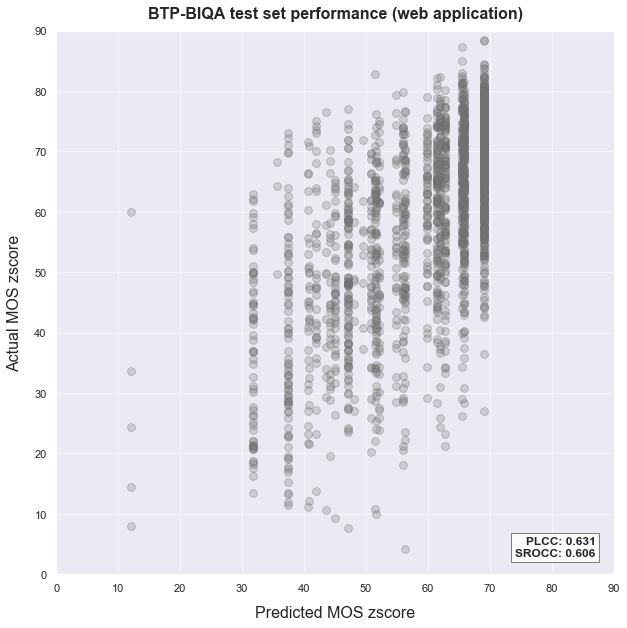

In [372]:
import pickle
import seaborn as sns
sns.set()
regressor = pickle.load(open('used_in_app_model.sav', 'rb'))
with open('features_y_test.json') as file_y:
    y_test = json.load(file_y)
with open('features_X_test.json') as file_X:
    X_test = json.load(file_X)
predicted = regressor.predict(X_test)
actual = y_test
plcc, p_plcc = stats.pearsonr(predicted, actual)
srocc, p_srocc = stats.spearmanr(predicted, actual)
mse = mean_squared_error(predicted, actual)
print("PLCC: " + str(plcc))
print("SROCC: " + str(srocc))
print("MSE: " + str(mse))
plt.figure(figsize = (10, 10))
plt.scatter(predicted, actual, color = '#71717140', edgecolor = '#71717160', s = 60)
plt.xlim(0, 90)
plt.ylim(0, 90)
plt.grid(alpha = 0.6)
plt.xlabel("Predicted MOS zscore", labelpad = 12, fontsize = 16)
plt.ylabel ("Actual MOS zscore", labelpad = 12, fontsize = 16)
plt.title('BTP-BIQA test set performance (web application)', pad = 12, fontweight = 'bold', fontsize = 16)
str_score = 'PLCC: ' + str(round(plcc, 3)) + '\n' + 'SROCC: ' + str(round(srocc, 3)) 
properties = dict(facecolor = 'white', alpha = 0.9, edgecolor = '#717171')
plt.text(87, 3, str_score, ha = 'right', bbox = properties, fontweight = 'bold')
# plt.plot([10, 90], [10, 90], color = "red")
plt.savefig('performance BTP-BIQA app.png', dpi=300)

In [140]:
print(regressor.feature_importances_)

[0.01496925 0.01541321 0.07623288 0.         0.         0.00096886
 0.00222901 0.         0.         0.00853656 0.10143782 0.06870008
 0.45735538 0.06847164 0.15865643 0.02702888]


Used in app
[0.01374267 0.02997422 0.07510226 0.         0.         0.00860653
 0.         0.         0.         0.         0.07296596 0.05970714
 0.51787995 0.04202579 0.1799955  0.        ]
 
Not used in app :( 
[0.01496925 0.01541321 0.07623288 0.         0.         0.00096886
 0.00222901 0.         0.         0.00853656 0.10143782 0.06870008
 0.45735538 0.06847164 0.15865643 0.02702888]

59


[Text(4001.1993243243246, 2523.8571428571427, 'sharpness2_area_2 <= 399.627\nmse = 257.01\nsamples = 3911\nvalue = 56.861'),
 Text(2149.054054054054, 2135.5714285714284, 'sharpness2_area_1 <= 398.29\nmse = 257.562\nsamples = 1183\nvalue = 44.702'),
 Text(1357.2972972972973, 1747.2857142857142, 'sharpness1_area_2 <= 616.824\nmse = 226.996\nsamples = 748\nvalue = 40.61'),
 Text(904.8648648648649, 1359.0, 'color <= 0.746\nmse = 213.993\nsamples = 397\nvalue = 36.094'),
 Text(678.6486486486486, 970.7142857142858, 'contrast <= 0.367\nmse = 223.5\nsamples = 255\nvalue = 38.516'),
 Text(452.43243243243245, 582.4285714285716, 'areas_1_size <= 0.384\nmse = 210.89\nsamples = 249\nvalue = 39.152'),
 Text(226.21621621621622, 194.14285714285734, 'mse = 213.406\nsamples = 183\nvalue = 37.347'),
 Text(678.6486486486486, 194.14285714285734, 'mse = 169.86\nsamples = 66\nvalue = 44.154'),
 Text(904.8648648648649, 582.4285714285716, 'mse = 33.948\nsamples = 6\nvalue = 12.132'),
 Text(1131.081081081081, 9

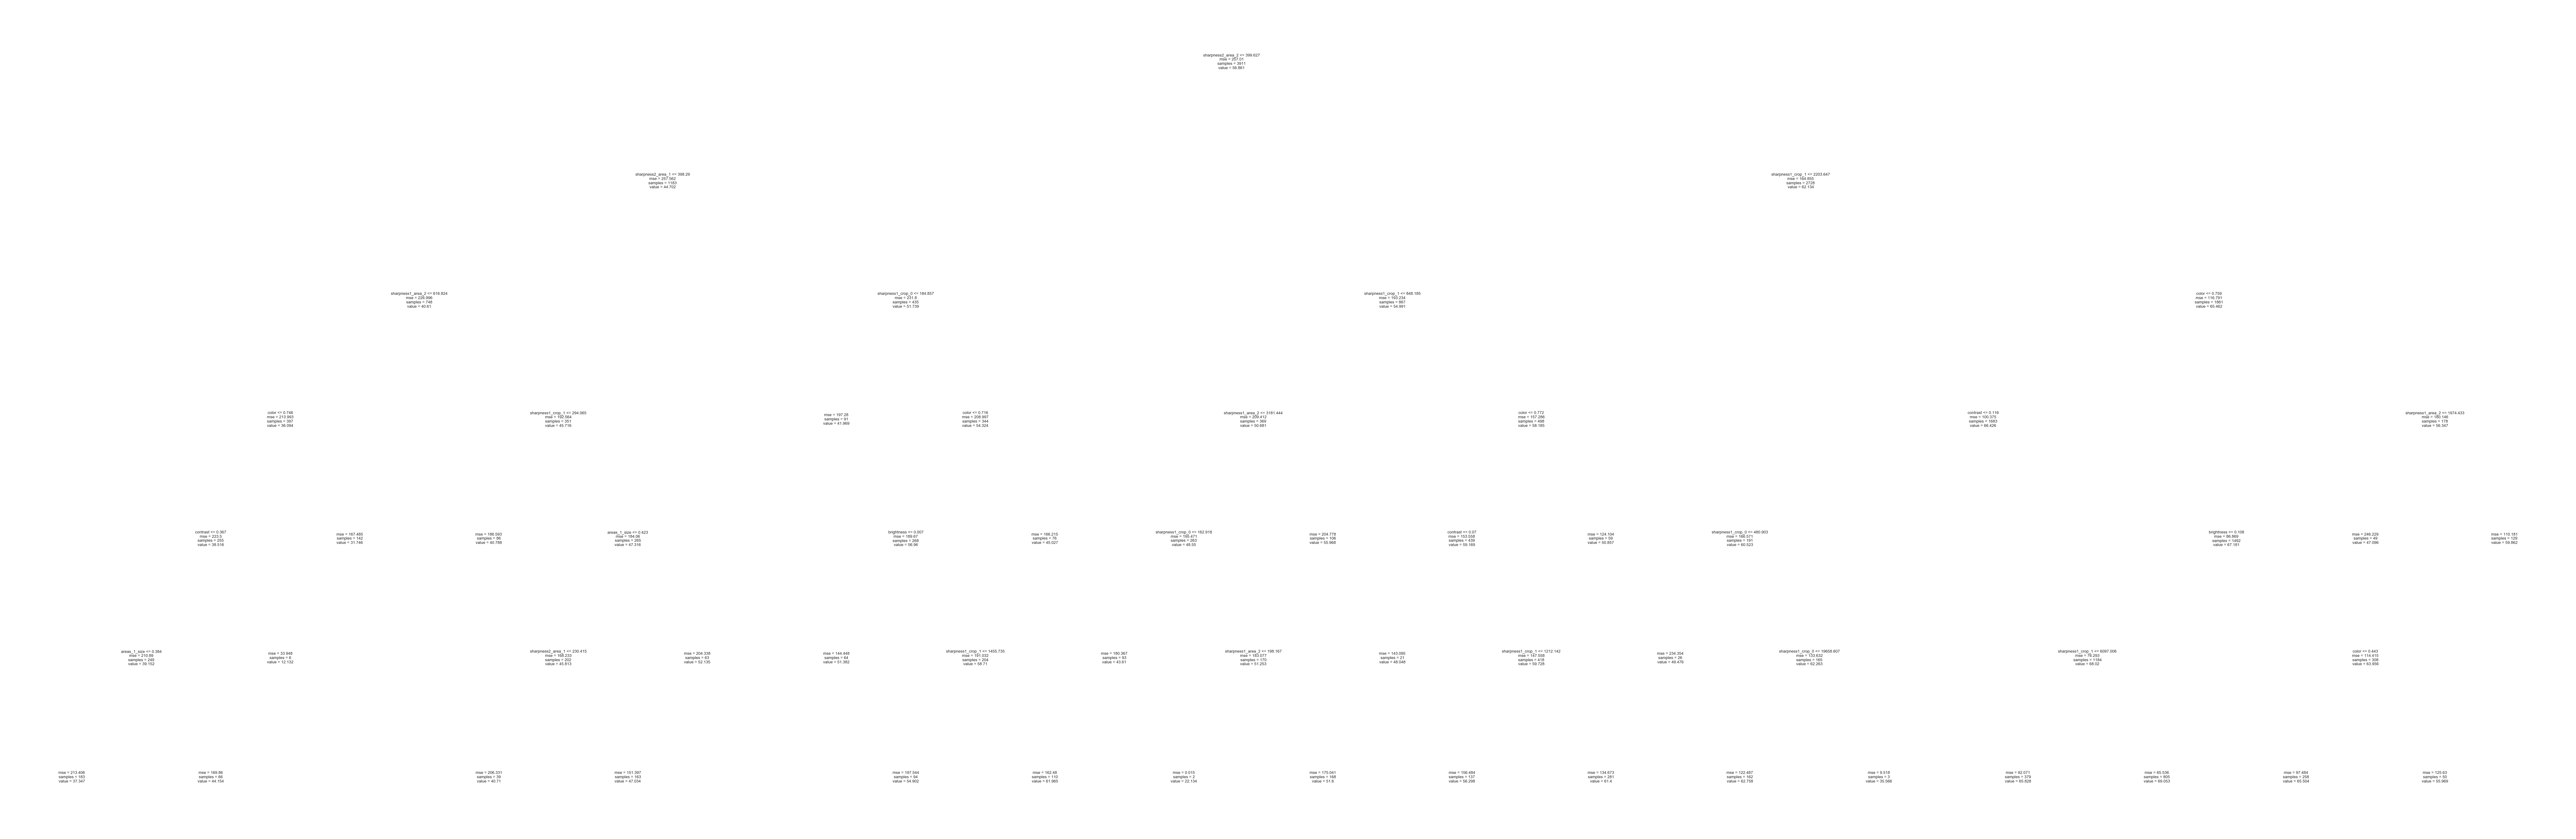

In [125]:
n_nodes = regressor.tree_.node_count
children_left = regressor.tree_.children_left
children_right = regressor.tree_.children_right
feature = regressor.tree_.feature
threshold = regressor.tree_.threshold
value = regressor.tree_.value

feature_names = ['brightness', 'contrast', 'color', 'areas_count', 'areas_0_size', 'areas_1_size', 'areas_2_size', 'sharpness1_area_0', 'sharpness2_area_0', 'sharpness1_area_1', 'sharpness2_area_1', 'sharpness1_area_2', 'sharpness2_area_2', 'sharpness1_crop_0', 'sharpness1_crop_1', 'noise']
print(n_nodes)
plt.figure(figsize = (150, 50))
tree.plot_tree(regressor, fontsize = 13, feature_names = feature_names)

In [236]:
def visualize_decision(sample):
    feature = clf.tree_.feature
    value = clf.tree_.value
    node_indicator = clf.decision_path([sample])
    feature_names = ['brightness', 'contrast', 'color', 'areas_count', 'areas_0_size', 'areas_1_size', 'areas_2_size', 'sharpness1_area_0', 'sharpness2_area_0', 'sharpness1_area_1', 'sharpness2_area_1', 'sharpness1_area_2', 'sharpness2_area_2', 'sharpness1_crop_0', 'sharpness1_crop_1', 'noise']
    category_scores = {'brightness': 0, 'contrast': 0, 'color': 0, 'areas': 0, 'sharpness': 0, 'noise': 0}
    node_index = node_indicator.indices[node_indicator.indptr[0]:
                                        node_indicator.indptr[1]]

    base_score = previous_score = value[0][0][0]
    for i, node_id in enumerate(node_index[:-1]):
        current_score = value[node_index[i + 1]][0][0]
        difference = current_score - previous_score
        previous_score = current_score
        feature_name = feature_names[feature[node_id]]
        
        for key in category_scores.keys():
            if feature_name.startswith(key):
                previous_cumulative = category_scores[key]
                current_cumulative = previous_cumulative + difference
                category_scores[key] = current_cumulative
                
    return([base_score, category_scores])
        
        

visualize_decision(X_test[7])
    

[56.86118919457706,
 {'brightness': 0,
  'contrast': 0,
  'color': -9.114316849327622,
  'areas': 0,
  'sharpness': 12.11479400560259,
  'noise': 0}]

5.272811450913885
3.3277310959637987
0.9639622098516156
0.7556882233988773
0.8390279314211
1.0322135324948079
[56.86118919457706, {'brightness': 0.8390279314211, 'contrast': 0.7556882233988773, 'color': 0.9639622098516156, 'areas': 0, 'sharpness': 9.632756079372491, 'noise': 0}]
Annotation(1867.23, 1514.31, 'sharpness2_area_2 <= 399.627\nmse = 257.01\nsamples = 3911\nvalue = 56.861')
Annotation(1867.23, 1514.31, 'sharpness1_crop_1 <= 2203.647\nmse = 164.855\nsamples = 2728\nvalue = 62.134')
Annotation(2731.56, 1281.34, 'color <= 0.759\nmse = 116.791\nsamples = 1861\nvalue = 65.462')
Annotation(3351.77, 1048.37, 'contrast <= 0.116\nmse = 100.375\nsamples = 1683\nvalue = 66.426')
Annotation(3008.68, 815.4, 'brightness <= 0.108\nmse = 86.869\nsamples = 1492\nvalue = 67.181')
Annotation(3378.16, 582.429, 'sharpness1_crop_1 <= 6097.006\nmse = 76.293\nsamples = 1184\nvalue = 68.02')
Annotation(3167.03, 349.457, 'mse = 65.536\nsamples = 805\nvalue = 69.053')


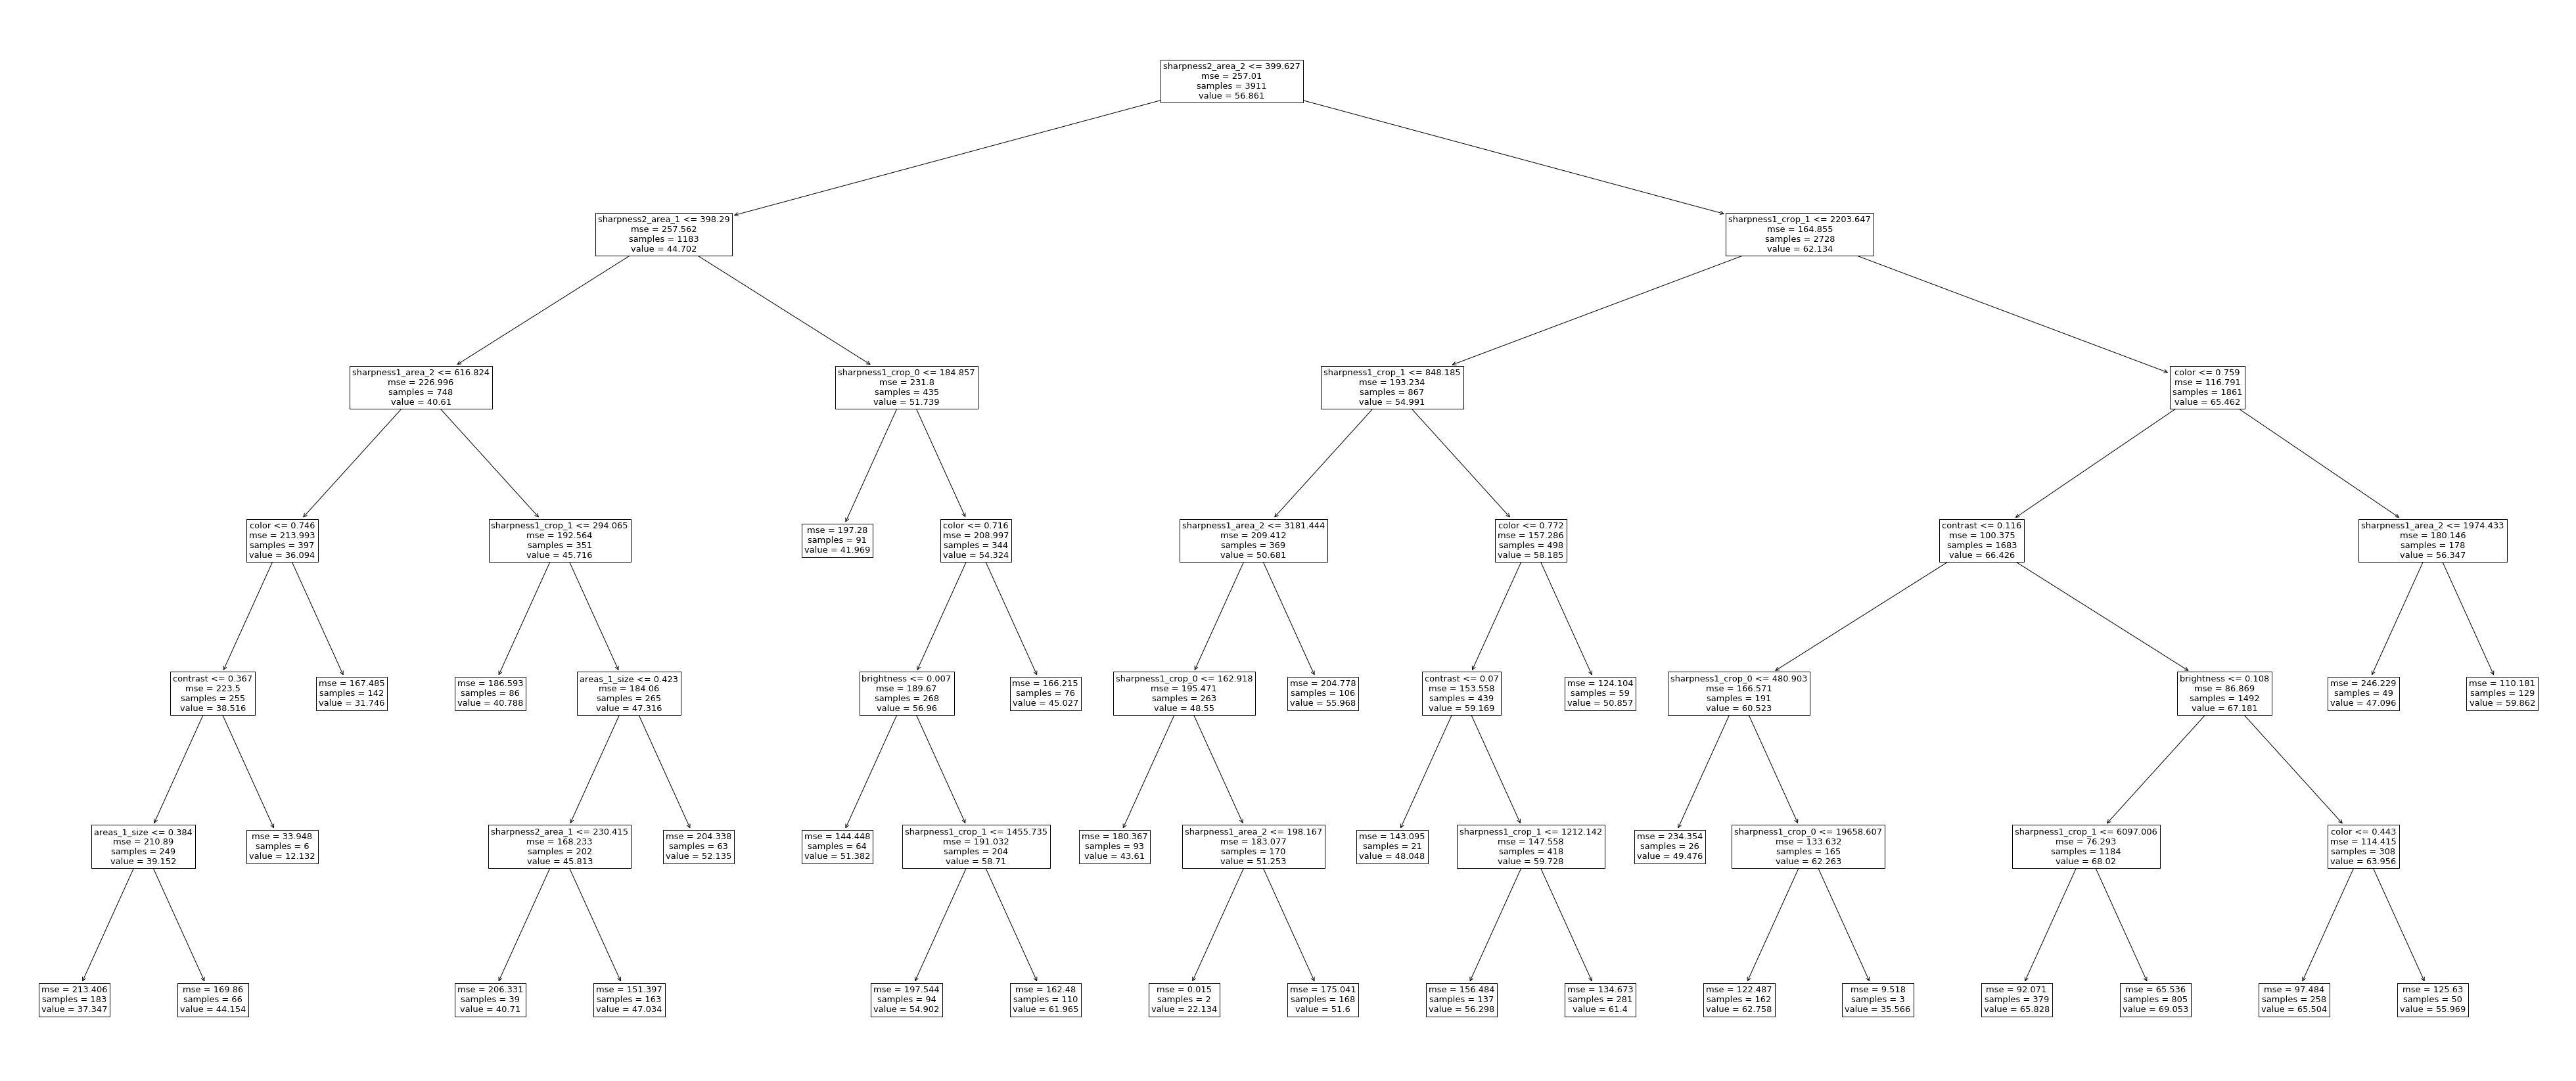

In [58]:
import pickle
regressor = pickle.load(open('used_in_app_model.sav', 'rb'))

df_illustrations = pd.read_csv('feature_df_illustrations.csv')
df_illustrations

for index, row in df_illustrations[:1].iterrows():
    sample = list(row)[1:]

feature = regressor.tree_.feature
value = regressor.tree_.value
node_indicator = regressor.decision_path([sample])
feature_names = ['brightness', 'contrast', 'color', 'areas_count', 'areas_0_size', 'areas_1_size', 'areas_2_size', 'sharpness1_area_0', 'sharpness2_area_0', 'sharpness1_area_1', 'sharpness2_area_1', 'sharpness1_area_2', 'sharpness2_area_2', 'sharpness1_crop_0', 'sharpness1_crop_1', 'noise']
category_scores = {'brightness': 0, 'contrast': 0, 'color': 0, 'areas': 0, 'sharpness': 0, 'noise': 0}
node_index = node_indicator.indices[node_indicator.indptr[0]:
                                    node_indicator.indptr[1]]

base_score = previous_score = value[0][0][0]
for i, node_id in enumerate(node_index[:-1]):
    current_score = value[node_index[i + 1]][0][0]
    difference = current_score - previous_score
    print(difference)
    previous_score = current_score
    feature_name = feature_names[feature[node_id]]

    for key in category_scores.keys():
        if feature_name.startswith(key):
            previous_cumulative = category_scores[key]
            current_cumulative = previous_cumulative + difference
            category_scores[key] = current_cumulative
            
print([base_score, category_scores])


plt.figure(figsize = (70, 30))
tree_figure = tree.plot_tree(regressor, fontsize = 13, feature_names = feature_names)
plt.savefig('Final Tree 5-7.png')
for node in node_index:
    print(tree_figure[node])